In [1]:
import torch
from PIL import Image
import random
import os
from torchvision import transforms
from timm.data.transforms import str_to_interp_mode
from config import _update_config_from_file
import numpy as np

In [976]:
# cementation_fissures crack longitudinal_crack loose massive_crack mending normal transverse_crack
class_map = ['cementation_fissures','crack', 'longitudinal_crack', 'loose', 'massive_crack', 'mending', 'normal', 'transverse_crack']
class_map = ['normal','distress']
class_name = 'cementation_fissures'
root_dir = '/home/tangwenhao/data/cqu_bpdd/test'
_dir = os.path.join(root_dir,class_name)
for root,dirs,files in os.walk(_dir):
    num_pic = len(files)

In [6]:
from config import get_config
config=get_config(None)
_update_config_from_file(config, '/home/tangwenhao/rdd_code/rdd_transformer/configs/rdd_trans.yaml')
_update_config_from_file(config, '/home/tangwenhao/rdd_code/rdd_transformer/configs/best/rdd_trans_70.yaml')
_update_config_from_file(config, '/home/tangwenhao/rdd_code/rdd_transformer/configs/best/rdd_trans_bin_979.yaml')

=> merge config from /home/tangwenhao/rdd_code/rdd_transformer/configs/rdd_trans.yaml
=> merge config from /home/tangwenhao/rdd_code/rdd_transformer/configs/best/rdd_trans_70.yaml
=> merge config from /home/tangwenhao/rdd_code/rdd_transformer/configs/best/rdd_trans_bin_979.yaml


In [7]:
from models import build_model
model = build_model(config)
# /home/tangwenhao/output/rdd_trans_new_init/model/rdd_trans_swin_small_patch4_window7_224_his_best_model.pth
# /home/tangwenhao/output/rdd_trans_bin_abl/model/rdd_trans_swin_small_patch4_window7_224clu_2_ema_best_model.pth
# /home/tangwenhao/output/rdd_trans_bin_abl/model/rdd_trans_swin_small_patch4_window7_224only_inst_ema_best_model.pth
# /home/tangwenhao/output/rdd_trans_new_abl_no_ADT/model/rdd_trans_swin_small_patch4_window7_224only_RDT_only_inst_test_ema_best_model.pth
cpt = torch.load('/home/tangwenhao/output/rdd_trans_new_abl_no_ADT/model/rdd_trans_swin_small_patch4_window7_224only_RDT_0.25_only_inst_ema_best_model.pth', map_location='cpu')

/home/tangwenhao/.local/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
model.load_state_dict(cpt['state_dict'], strict=False)

<All keys matched successfully>

In [18]:
ins = {'weight':cpt['state_dict'].pop('instance_feature_extractor.head_instance.weight'),'bias':cpt['state_dict'].pop('instance_feature_extractor.head_instance.bias')}
model.load_state_dict(cpt['state_dict'], strict=False)
model.head_instance.load_state_dict(ins)

<All keys matched successfully>

In [1048]:
_file = random.randint(0, num_pic)
img = Image.open(os.path.join(_dir,str(_file)+'.jpg')).convert('RGB')

In [1049]:
imgs = transforms.Resize(size=(224,224),interpolation=str_to_interp_mode('bicubic'))(img=img)
imgs = transforms.ToTensor()(imgs)
imgs = transforms.Normalize(mean=torch.tensor((0.485, 0.456, 0.406)),std=torch.tensor((0.229, 0.224, 0.225)))(imgs)
imgs = imgs.unsqueeze(0)

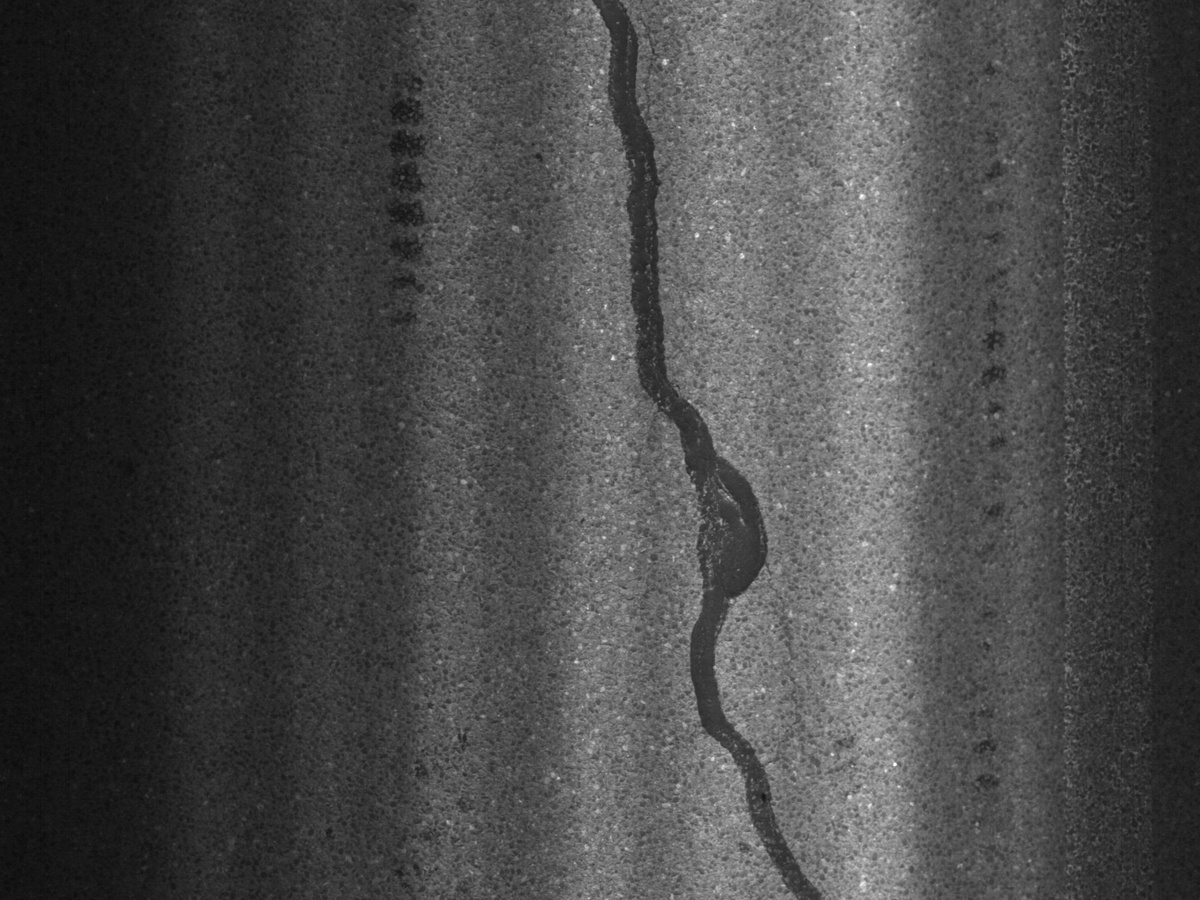

In [1050]:
img

In [1051]:
model.eval()
with torch.no_grad():
    _,ins_feat = model.instance_feature_extractor.forward_features(imgs)
    output = model(imgs)
    clusters_idcs,clusters_mask = model.sklearn_cluster(ins_feat)
    _,_,cluster_selected,scores = model.cluster_classifier(ins_feat,None,clusters_idcs,thr=0.99,cluster_num = 2,clusters_mask=clusters_mask)

In [25]:
cluster_selected

tensor([[False,  True]])

In [26]:
scores

tensor([[0.3160, 0.1857]])

In [11]:
clusters_idcs[0]

tensor([1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        1], device='cuda:0')

In [1052]:
softmax=torch.nn.Softmax(-1)
bag_output = softmax(output[0])
inst_output = softmax(output[1])[0]
inst_max_output,inst_max_idic=torch.max(inst_output,dim=-1)

In [14]:
inst_output[:,0]

tensor([2.1389e-01, 8.2423e-01, 1.3351e-01, 1.7945e-01, 4.4642e-02, 8.4555e-01,
        6.3311e-01, 9.8975e-01, 6.6552e-01, 2.9334e-02, 3.9639e-03, 3.5497e-03,
        3.5321e-01, 9.9516e-01, 9.8751e-01, 9.9106e-01, 8.5705e-01, 8.5674e-01,
        1.2937e-02, 9.5989e-01, 9.9866e-01, 9.7821e-01, 2.2588e-01, 4.8837e-03,
        3.1447e-04, 9.3080e-04, 4.5505e-02, 9.2391e-01, 9.9332e-01, 8.6799e-01,
        1.4722e-02, 3.6922e-03, 1.4831e-03, 7.7431e-02, 9.9571e-01, 9.6381e-01,
        9.0444e-01, 5.3206e-02, 1.4523e-02, 1.9486e-02, 7.3716e-01, 9.9101e-01,
        2.1097e-01, 8.5681e-01, 1.5508e-01, 6.4168e-02, 1.6922e-02, 9.2932e-01,
        3.8477e-01])

In [1057]:
# save pic
from PIL import ImageDraw,ImageFont
img_d = transforms.Resize(size=(896,896),interpolation=str_to_interp_mode('bicubic'))(img=img)
rectangle = img_d.copy()
draw = ImageDraw.Draw(rectangle)

#font=ImageFont.truetype(size=10)
for i in range(0,len(inst_output)):
    row = int(i / 7)
    col = i % 7
    
    #if class_map[inst_max_idic[i]] != 'normal' and inst_max_output[i].item() >0.99735:
    if inst_output[i][1] > 0.87:
        draw.rectangle((col*128,row*128,(col+1)*128,(row+1)*128),fill="#c00000",outline=None)
    else:
        pass
    draw.rectangle((col*128,row*128,(col+1)*128,(row+1)*128),fill=None,outline="white")
    #draw.text((col*128,row*128),class_map[inst_max_idic[i]][:4]+'  '+str(inst_max_output[i].item())[:7]+ '  '+str(clusters_idcs[0][i].item()),fill='white')
blended = Image.blend(img_d, rectangle, 0.35)

In [1055]:
# 128
from PIL import ImageDraw,ImageFont
img_d = transforms.Resize(size=(896,896),interpolation=str_to_interp_mode('bicubic'))(img=img)
rectangle = img_d.copy()
draw = ImageDraw.Draw(rectangle)

#font=ImageFont.truetype(size=10)
for i in range(0,len(inst_output)):
    row = int(i / 7)
    col = i % 7
    # class_map[inst_max_idic[i]] != 'normal' and if inst_max_output[i].item() > 0.2:
    if inst_output[i][1] > 0.87:
        draw.rectangle((col*128,row*128,(col+1)*128,(row+1)*128),fill="#c00000",outline=None)
    else:
        pass
    draw.rectangle((col*128,row*128,(col+1)*128,(row+1)*128),fill=None,outline="white")
    draw.text((col*128,row*128),class_map[inst_max_idic[i]][:4]+'  '+str(inst_max_output[i].item())[:7]+ '  '+str(clusters_idcs[0][i].item()),fill='white')
blended = Image.blend(img_d, rectangle, 0.35)

In [123]:
bag_output

tensor([[2.8685e-03, 8.4128e-06, 6.1164e-03, 3.4828e-04, 2.0719e-05, 1.1054e-05,
         9.8387e-01, 6.7611e-03]])

In [1059]:
blended.save('./output/bin_rdt_tea_test_cf_9.eps')

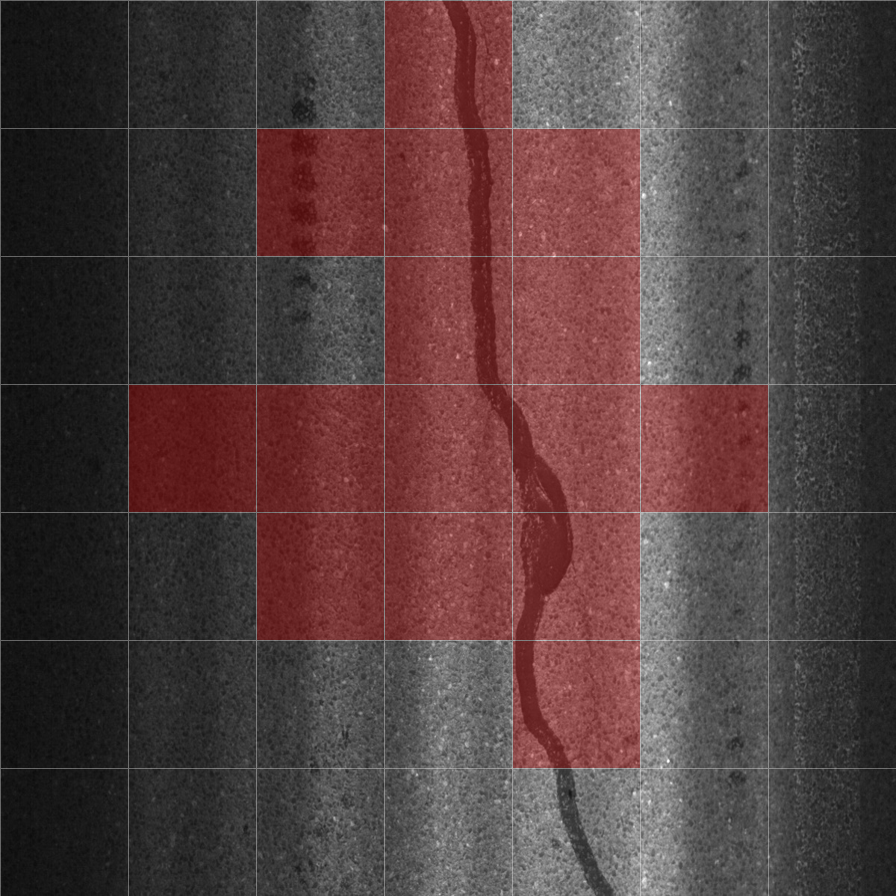

In [1058]:
blended.show()

## CAM

In [103]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [10]:
config=get_config(None)
_update_config_from_file(config, '/home/tangwenhao/rdd_code/rdd_transformer/configs/baseline/rdd_swin_small.yaml')
from models import build_model
model_b = build_model(config)
cpt = torch.load('/home/tangwenhao/output/swin/model/swin_small_patch4_window7_224_best_model.pth', map_location='cpu')
model_b.load_state_dict(cpt['state_dict'], strict=False)
_ = model_b.eval()

=> merge config from /home/tangwenhao/rdd_code/rdd_transformer/configs/baseline/rdd_swin_small.yaml


In [104]:
def reshape_transform(tensor, height=7, width=7):
    result = tensor.reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [12]:
with torch.no_grad():
    a = model_b(imgs)

In [13]:
softmax(a)

NameError: name 'softmax' is not defined

In [105]:
target_layers = [model.instance_feature_extractor.layers[-1].blocks[-1].norm1]

In [15]:
target_layers_b = [model_b.layers[-1].blocks[-1].norm1]

In [16]:
cam_b = GradCAM(model=model_b, target_layers=target_layers_b, reshape_transform=reshape_transform)

In [106]:
cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

In [107]:
target_category = [ClassifierOutputTarget(0)]
grayscale_cam = cam(input_tensor=imgs,
                    targets=target_category,)

In [19]:
target_category_b = [ClassifierOutputTarget(2)]
grayscale_cam_b = cam_b(input_tensor=imgs,
                    targets=target_category_b,)

In [20]:
# Here grayscale_cam has only one image in the batch
grayscale_cam_b = grayscale_cam_b[0, :]
rgb_img = cv2.resize(np.array(img), (224, 224))
rgb_img = np.float32(rgb_img) / 255
cam_image_b = show_cam_on_image(rgb_img, grayscale_cam_b,use_rgb=True)

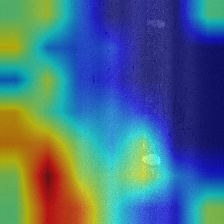

In [21]:
Image.fromarray(cam_image_b)

In [108]:
# Here grayscale_cam has only one image in the batch
grayscale_cam = grayscale_cam[0, :]
rgb_img = cv2.resize(np.array(img), (224, 224))
rgb_img = np.float32(rgb_img) / 255
cam_image = show_cam_on_image(rgb_img, grayscale_cam,use_rgb=True)

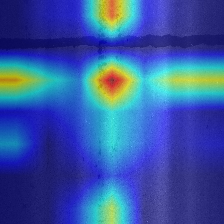

In [109]:
Image.fromarray(cam_image)

In [132]:
save_path = './output/heatmap/baseline_1.jpg'
if os.path.exists(save_path):
    save_path = save_path.replace(save_path[26:-4],str(int(save_path[26:-4])+1))
Image.fromarray(cam_image_b).save(save_path,quality=95)
img.save(save_path.replace('baseline','ori'),quality=95)
Image.fromarray(cam_image).save(save_path.replace('baseline','pict'),quality=95)

with open('./output/heatmap/cat.txt','a',encoding='utf-8') as f:
    text = '\n'+save_path[26:-4]+' '+ class_name
    f.write(text)
f.close()

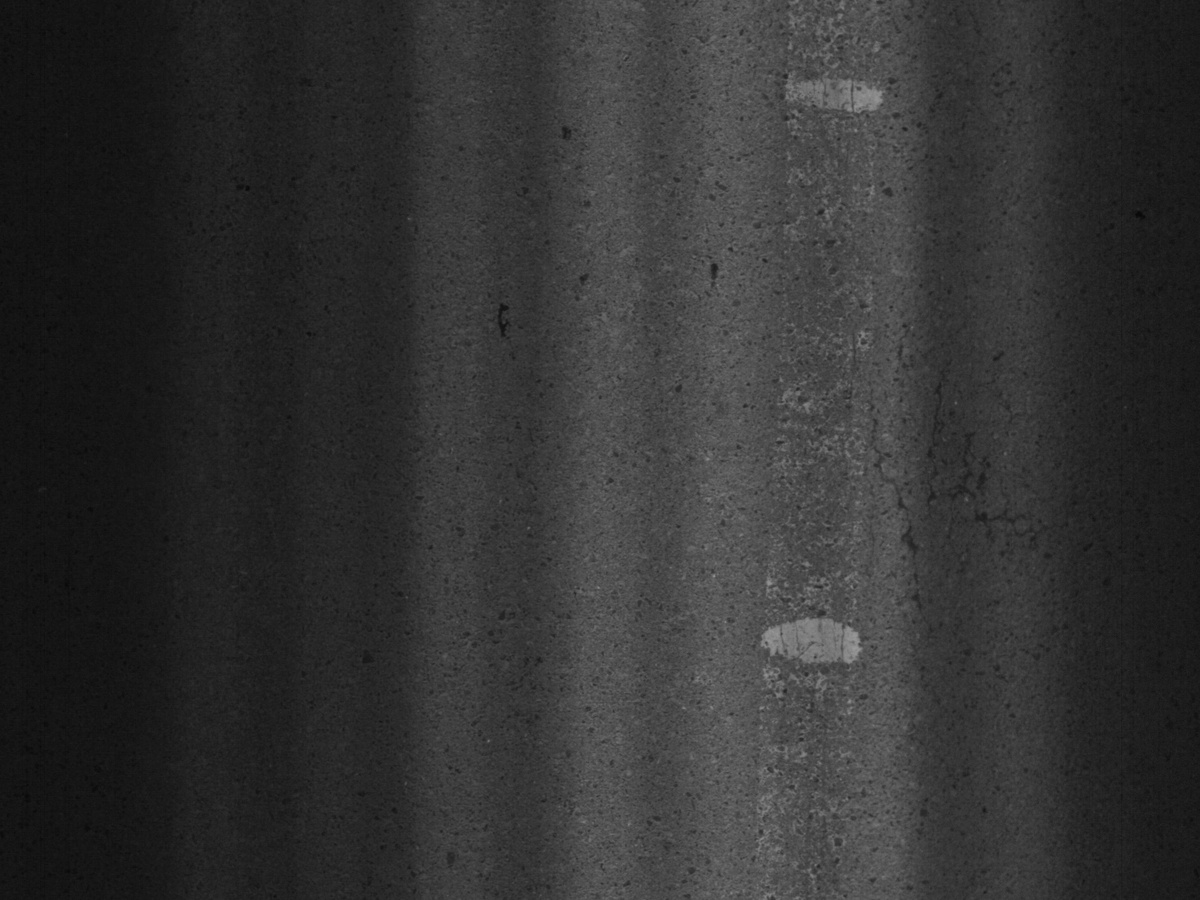

In [24]:
img

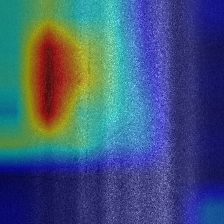

In [112]:
Image.fromarray(cam_image)

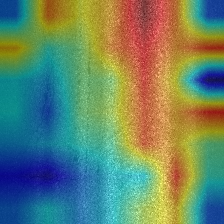

In [125]:
Image.fromarray(cam_image)

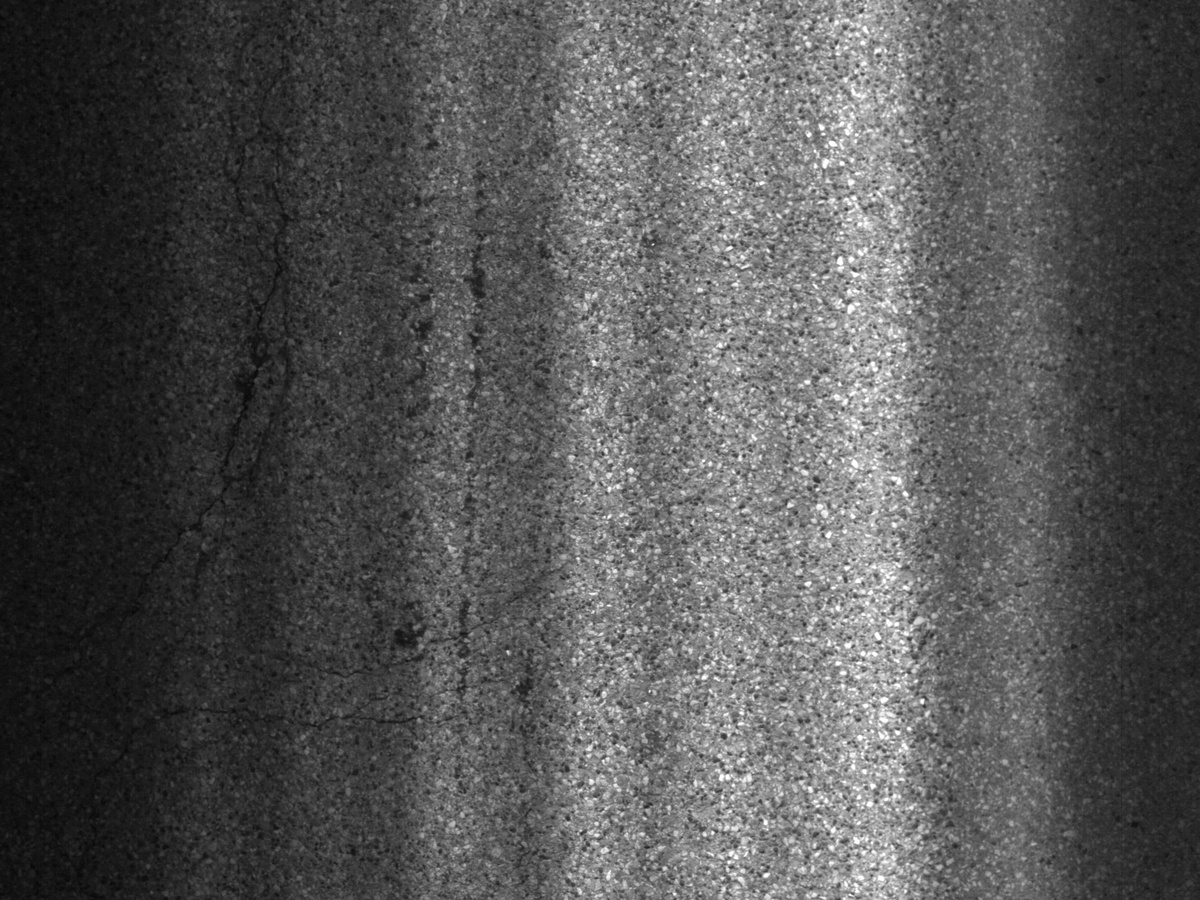

In [113]:
img